### Необходимые импорты

In [1]:
%pip install faker
%pip install matplotlib
%pip install nbformat
%pip install numpy
%pip install pandas
%pip install plotly
%pip install psycopg2
%pip install seaborn

from IPython.display import clear_output
clear_output()

In [2]:
from IPython.display import clear_output
from decimal import *
from dotenv import load_dotenv
from faker import Faker
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import psycopg2
import random
import time

### Подключение к базе данных

In [3]:
load_dotenv()

db_name = 'project'
db_user = os.environ.get("DB_USER")
db_password = os.environ.get("DB_PASSWORD")
db_host = os.environ.get("DB_HOST")
db_port = os.environ.get("DB_PORT")

# Подключение к базе данных
conn = psycopg2.connect(
    dbname=db_name,
    user=db_user,
    password=db_password,
    host=db_host,
    port=db_port
)

# Создание курсора для выполнения SQL запросов
cursor = conn.cursor()

Выгружаем все таблицы в формате `pandas.DataFrame`

In [4]:
 # Получаем список всех таблиц
query = """
    SELECT table_name
    FROM information_schema.tables
    WHERE table_schema = 'sutk'
"""
cursor.execute(query)
tables = [table[0] for table in cursor.fetchall()]

# Выгружаем таблицы по названиям
dfs = {}
for table in tables:
    query = f"SELECT * FROM sutk.{table}"
    dfs[table] = pd.read_sql_query(query, conn)

clear_output()
print(f'Выгружены таблицы: \n - {"\n - ".join(tables)}')

Выгружены таблицы: 
 - ordered_products
 - products
 - physical_entities
 - legal_entities
 - storage
 - orders_progress
 - addresses
 - orders
 - departments
 - workers
 - clients
 - order_statuses
 - status_types


Завершение работы с базой данных

In [5]:
conn.commit()
cursor.close()
conn.close()

## Анализ данных

Создаем удобный столбец `process_days` для анализа

In [6]:
dfs['order_statuses']['process_days'] = [x.days if x is not np.nan else 0 for x in dfs['order_statuses']['to_date'] - dfs['order_statuses']['from_date']]

#### График количества заказов по статусам

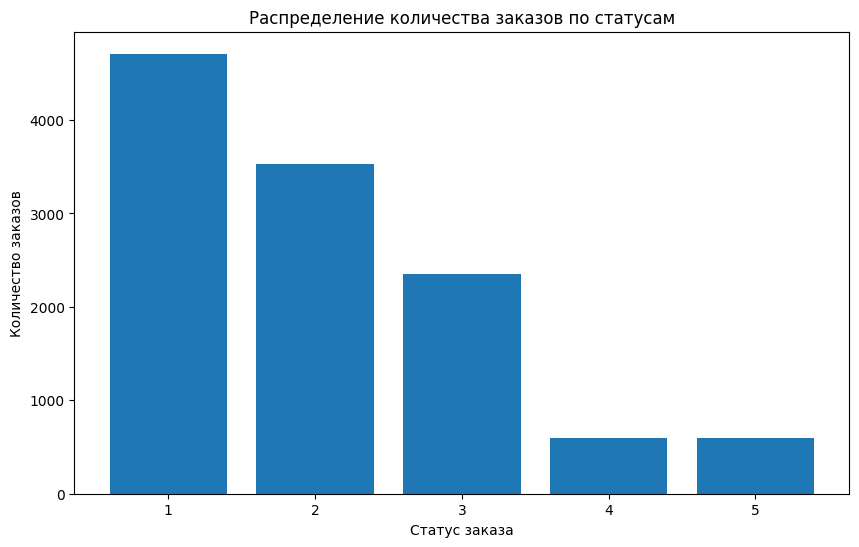

In [7]:
plt.figure(figsize=(10, 6))
order_statuses_counts = dfs['order_statuses'].groupby('status_id').count()
plt.bar(order_statuses_counts.index, order_statuses_counts['order_id'])
plt.xlabel('Статус заказа')
plt.ylabel('Количество заказов')
plt.title('Распределение количества заказов по статусам')
plt.show()

#### График зависимости времени обработки заказа от статуса заказа

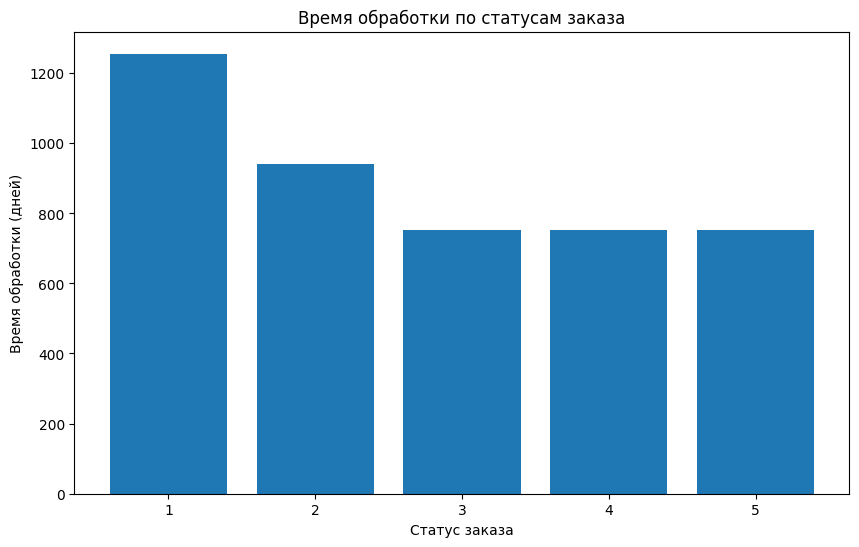

In [8]:
plt.figure(figsize=(10, 6))
order_statuses_processing_times = dfs['order_statuses']
plt.bar(order_statuses_processing_times['status_id'], order_statuses_processing_times['process_days'])
plt.xlabel('Статус заказа')
plt.ylabel('Время обработки (дней)')
plt.title('Время обработки по статусам заказа')
plt.show()

#### График зависимости времени обработки заказа от статуса заказа и работника для первых 10 работников (для удобства)

In [9]:
combined_df = pd.merge(dfs['order_statuses'], dfs['status_types'], on='status_id')

fig = go.Figure()
for worker_id in dfs['workers']['worker_id'].unique()[:10]:
    worker_data = combined_df[combined_df['worker_id'] == worker_id]
    fig.add_trace(go.Box(
        x=worker_data['name'],
        y=worker_data['process_days'],
        name=f'Работник {worker_id}'
    ))
fig.update_layout(title='Время обработки по статусу заказа и работнику', xaxis_title='Статус заказа', yaxis_title='Время обработки (в днях)')

#fig.show()
fig.write_html("./workers.html")

#### График частоты заказанных продуктов за все время работы компании

In [10]:
combined_df = pd.merge(dfs['ordered_products'], dfs['products'], on='product_id')

product_counts = combined_df.groupby('name').count()

fig = px.bar(product_counts, x=product_counts.index, y='order_id')
fig.update_layout(title='Частота заказанных продуктов', xaxis_title='Название продукта', yaxis_title='Количество заказов')
fig.update_traces(hoverinfo="all", hovertemplate="Название: %{x}<br>Количество заказов: %{y}")
fig.show()